In [517]:
%matplotlib inline

Define the model
----------------




In [585]:
import math
from typing import Tuple
import torch
from torch import nn, Tensor
import torch.nn.functional as F
from torch.nn import TransformerEncoder, TransformerEncoderLayer
from torch.utils.data import dataset

class TransformerModel(nn.Module):

    def __init__(self, ntoken: int, d_model: int, nhead: int, d_hid: int, 
                 nlayers: int, dropout: float = 0.5):
        super().__init__()
        self.model_type = 'Transformer'
        self.pos_encoder = PositionalEncoding(d_model, dropout) #NOTE d_model is the embedding size
        encoder_layers = TransformerEncoderLayer(d_model, nhead, d_hid, dropout)
        self.transformer_encoder = TransformerEncoder(encoder_layers, nlayers)
        # self.encoder = nn.Embedding(ntoken, d_model) # NOTE: Do not need embedding for IPS, the data itself has 384 dimensional data
        self.d_model = d_model
        self.decoder = nn.Linear(d_model, ntoken)
        self.doa_embedding = DOAEncoding(d_model)

        self.init_weights()

    def init_weights(self) -> None:
        initrange = 0.1
        # self.encoder.weight.data.uniform_(-initrange, initrange)
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self, src: Tensor, src_doa:Tensor, src_mask: Tensor) -> Tensor:
        """
        Args:
            src: Tensor, shape [seq_len, batch_size] #! Make the src to be a tuple, (csi, doa)
            src_mask: Tensor, shape [seq_len, seq_len]

        Returns:
            output Tensor of shape [seq_len, batch_size, ntoken]
        """
        # src = self.encoder(src) * math.sqrt(self.d_model) #! the input is 35(just consider it to be # of batches) by 20, the output is 35 by 20 by 200. The embedding turns the indices into vectors of size 200.
        
        # note: with DOA         
        src_doa = self.doa_embedding(src_doa) #!HACK: NOTE: DOA embedding should be in from of the pos encoding !!
        # print('src and src_doa shape', src.shape, src_doa.shape)
        # src = src + src_doa
        src = src_doa

        src = self.pos_encoder(src)
        
        output = self.transformer_encoder(src, src_mask) #! the output is the output of the final fully-connected layer of 200 dimension. The dimension here is still the same as 35 by 20 by 200
        output = self.decoder(output) #! The linear layer in the decoder maps the input from 35 by 20 by 200 to 35 by 20 by ntoken (好像是两万多)
        return output

def generate_square_subsequent_mask(sz: int) -> Tensor:
    """Generates an upper-triangular matrix of -inf, with zeros on diag."""
    return torch.triu(torch.ones(sz, sz) * float('-inf'), diagonal=1)

In [519]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000): # max_len means the maximum time steps or word length
        super().__init__()
        self.dropout = nn.Dropout(p=dropout) # do not understand why you need dropout here

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model)) #1/10000^(2i/dim_model)) #! exp(ln(x))=x, therefore, exp(ln(1/10000^(2i/dim_model)))) = exp(2i/dim_model)*(-ln(10000))
        pe = torch.zeros(max_len, 1, d_model) #NOTE: Row always means the 
        pe[:, 0, 0::2] = torch.sin(position * div_term) #PE(pos, 2i) = sin(pos/10000^(2i/dim_model))
        pe[:, 0, 1::2] = torch.cos(position * div_term) #PE(pos, 2i) = cos(pos/10000^(2i/dim_model))
        self.register_buffer('pe', pe)

    def forward(self, x: Tensor) -> Tensor:
        """
        Args:
            x: Tensor, shape [seq_len, batch_size, embedding_dim]
        """
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)

In [544]:
class DOAEncoding(nn.Module):
    def __init__(self, d_model: int, dropout: float = 0.1): # max_len means the maximum time steps or word length
        super().__init__()
        # self.dropout = nn.Dropout(p=dropout) # do not understand why you need dropout here

        self.embedding_layer = nn.Embedding(num_embeddings=512, # zzf: this value depends on the unique value of the DoA
                               embedding_dim=d_model)
                            #    padding_idx=1)
    def forward(self, x: Tensor) -> Tensor:
        """
        Args:
            x: Tensor, shape [seq_len, batch_size, embedding_dim]
        """
        return self.embedding_layer(x)

Load and batch data
-------------------




In [521]:
import scipy.io as sio
from scipy.io import loadmat, savemat
import numpy as np
import os
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import matplotlib.pyplot as plt
from einops import rearrange,reduce,repeat

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

##### load training data

In [545]:
dataPath = './matlab_input_data/2/features_1d_30snr' #
# labelPath = 'label_10cm'
input_data_train = sio.loadmat(dataPath)
input_data_train = torch.from_numpy(input_data_train['features'])
# labels = sio.loadmat(labelPath)
# labels = torch.from_numpy(labels['label'] )
input_data_train.shape

torch.Size([24, 8, 4, 3871])

Shuffle the data set since all the samples are arranged in the order where SNR being -10 to 20 sequentially. 

In [224]:
# input_data_reshape = rearrange(input_data_train, 'a b c d e-> d a b c e')
# print(input_data_reshape.shape)
# rng = np.random.default_rng()
# input_data_shuffle = rng.permuted(input_data_reshape,axis=0) # axis = 0, shuffle the lowest dimension. 
# print('shuffled data size is', input_data_shuffle.shape)

##### preprocessing training data

In [546]:
n_trajectories = 49
n_pts_trajectory = 79
# Change the original data dimension [3871, 4, 4, 24] to [79 x 49 x 4 x 4 x 24] 
## NOTE: The following code is for training dataset of multiple SNR case
# input_data_reshape = rearrange(torch.from_numpy(input_data_shuffle), 'a b c d e-> e a d c b')
## NOTE: The following code is for training dataset of single SNR case
input_train_data_reshape = rearrange((input_data_train), 'a b c d-> d c b a')
print('input_train_data_reshape',input_train_data_reshape.shape)
train_data_trajectory = input_train_data_reshape.chunk(n_pts_trajectory) #! divide the data into chunks
train_data = torch.stack([item for item in train_data_trajectory]) # [79 x 49 x 4 x 4 x 24]
print('training data size',train_data.shape) #note the third dimension is # of SNR from -10 to 30

# print(f'the number of traing and test dataset is {len(train_data)} and {len(test_data)}')
# print(f'the size of the traning data is {train_data.shape}')
# change the size of the from [79 x 49 x 4 x 4 x 24] to [79 x 49 x 384]
train_data = rearrange(train_data, 'a b c d e-> a b (c d e)').to(device)
print('training data size',train_data.shape) #note the third dimension is # of SNR from -10 to 30


input_train_data_reshape torch.Size([3871, 4, 8, 24])
training data size torch.Size([79, 49, 4, 8, 24])
training data size torch.Size([79, 49, 768])


##### load DOA data

In [577]:
dataPath = './matlab_input_data/2/doa_input_1d_30snr' #
input_data_doa = sio.loadmat(dataPath)
input_data_doa = torch.from_numpy(input_data_doa['doa_input'])
input_data_doa = torch.squeeze(input_data_doa)
input_data_doa = input_data_doa.type(torch.cuda.LongTensor) #! HACK: Embedding layer only accepts the LongTensor Type
data_doa_chunk = input_data_doa.chunk(n_pts_trajectory) #! divide the data into chunks
train_data_doa = torch.stack([item for item in data_doa_chunk]).to(device) # [79 x 49 x 4 x 4 x 24]
print('doa data size',train_data_doa.shape)

doa data size torch.Size([79, 49])


In [530]:
print(train_data_doa.shape)
max(train_data_doa)

torch.Size([3871])


tensor(392, device='cuda:0')

##### load test data (snr = 10)

In [431]:
dataPath = './matlab_input_data/features_minus10_to_30snr'
# labelPath = 'labels_1d_0snr'
input_data_test = sio.loadmat(dataPath)
input_data_test = torch.from_numpy(input_data_test['features'])
# labels_test = sio.loadmat(labelPath)
# labels_test = torch.from_numpy(labels_test['label'] )
print('the input data size is',input_data_test.shape)

the input data size is torch.Size([24, 4, 4, 41, 3871])


##### Preprocess test data

In [432]:
input_test_data_reshape = rearrange(input_data_test, 'a b c d e -> e d c b a')

data_trajectory_test = input_test_data_reshape.chunk(n_pts_trajectory) #! divide the data into chunks
data_stack_test = torch.stack([item for item in data_trajectory_test]) # [79 x 49 x 4 x 4 x 24]
print('test data size',data_stack_test.shape)

## NOTE: The following code is for training dataset of multiple SNR case
test_data = rearrange(data_stack_test, 'a b c d e f-> c a b (d e f)').to(device) #NOTE: the first dimension is # of SNR (-10:30 dB)
## NOTE: The following code is for training dataset of single SNR case
# input_data_reshape_test = rearrange(input_data_test, 'a b c d -> d c b a')
print(f'the size of the test data is {test_data.shape}')

# # Creating labels from 0 to 3870

test data size torch.Size([79, 49, 41, 4, 4, 24])
the size of the test data is torch.Size([41, 79, 49, 384])


#### Generate Labels for all positions 

In [531]:
labels_ips = torch.arange(0,3871)
# Change the label dimension from 1d to [79 x 49]
labels_ips = labels_ips.reshape(49, 79).t().to(device)
print('label shape',labels_ips.shape)

label shape torch.Size([79, 49])


In [532]:
n_pts_once = 40 #NOTE: batch dimension N, the length of each batch. In IPS, it means the number of points considered at once
def get_batch(source: Tensor, source_doa: Tensor, label: Tensor, i: int) -> Tuple[Tensor, Tensor]: 
    """
    Args:
        source: Tensor, shape [num_pts, batch_size] NOTE: batch_size = # of trajectories
        label: Tensor, shape [num_pts, batch_size]
        i: int

    Returns:
        tuple (data, target), where data has shape [num_pts, batch_size] and
        target has shape [num_pts * batch_size]
    """
    seq_len = min(n_pts_once, len(source) - 1 - i)  #! The actual value for i is [0 35 70 105,...]
    data = source[i:i+seq_len]
    data_doa = source_doa[i:i+seq_len]
    target = label[i+1:i+1+seq_len].reshape(-1) #! reshape(-1) will unfold the matrix from the higher dimension to the lower dimension
    return data,data_doa,target

Initiate an instance
--------------------




In [586]:
ntokens = 3871  # there are 3871 points!!
emsize = 768  # 384 # the data sample dimension for each point (similar to embedding dimension here)
d_hid = 1024  # dimension of the feedforward network model in nn.TransformerEncoder %NOTE: default is 2048
nlayers = 2  # number of nn.TransformerEncoderLayer in nn.TransformerEncoder
nhead = 4  # number of heads in nn.MultiheadAttention
dropout = 0.1  # dropout probability % 0.2
traj_length = 79
model = TransformerModel(ntokens, emsize, nhead, d_hid, nlayers, dropout).to(device)

Run the model
-------------




In [592]:
import copy
import time

criterion = nn.CrossEntropyLoss()
lr = 5.0  # learning rate
# optimizer = torch.optim.SGD(model.parameters(), lr=lr)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 15.0, gamma=0.95) # after one epoch, the LR becomes 95% of the original LR

In [535]:
train_data = test_data[25]
train_data.shape

torch.Size([79, 49, 384])

In [590]:
def train(model: nn.Module) -> None:
    model.train()  # turn on train mode
    total_loss = 0.
    log_interval = 10
    start_time = time.time()
    src_mask = generate_square_subsequent_mask(n_pts_once).to(device)
    num_batches = traj_length // n_pts_once
    
    # for    batch, i in enumerate(range(0, train_data.size(0) - 1, n_pts_once)): #(0 35 70 ...) #NOTE: `-1` is for batching the target value
    for batch, i in enumerate(range(0, train_data.size(0) - 1, 1)): #(0 35 70 ...) #NOTE: `-1` is for batching the target value
        data, data_doa, targets = get_batch(train_data,train_data_doa, labels_ips, i) # i = 0, 35,70, ... len(train_data) #! The size of data is 35 by 20, 20 is the batch size
        batch_size = data.size(0)

        if batch_size != n_pts_once:  # only on last batch
            src_mask = src_mask[:batch_size, :batch_size] 
        output = model(data, data_doa, src_mask) #! The shape of the output is (35, 20, 28782)
        loss = criterion(output.view(-1, ntokens), targets) #! out.view(-1,ntokens) will make the shape (35,20,28782) to (700,28782)
        
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
        optimizer.step()
        

        # total_loss += loss.item()
        # if batch % log_interval == 0 and batch > 0:
        #     lr = scheduler.get_last_lr()[0]
        #     ms_per_batch = (time.time() - start_time) * 1000 / log_interval
        #     cur_loss = total_loss / log_interval
        #     ppl = math.exp(cur_loss)
        #     print(f'| epoch {epoch:3d} | {batch:5d}/{num_batches:5d} batches | '
        #             f'lr {lr:02.6f} | ms/batch {ms_per_batch:5.2f} | '
        #             f'loss {cur_loss:5.2f} | ppl {ppl:8.2f}')
        #     total_loss = 0
        #     start_time = time.time()

def evaluate(model: nn.Module, eval_data: Tensor, eval_data_doa:Tensor, labels: Tensor) -> float:
    model.eval()  # turn on evaluation mode
    total_loss = 0.
    src_mask = generate_square_subsequent_mask(n_pts_once).to(device)
    with torch.no_grad():
        for i in range(0, eval_data.size(0) - 1, n_pts_once):
            data, data_doa,targets = get_batch(eval_data, eval_data_doa,labels, i)
            batch_size = data.size(0)
            if batch_size != n_pts_once:
                src_mask = src_mask[:batch_size, :batch_size]
            output = model(data, data_doa,src_mask)
            output_flat = output.view(-1, ntokens)
            total_loss += batch_size * criterion(output_flat, targets).item()
    return total_loss / (len(eval_data) - 1)

Loop over epochs. Save the model if the validation loss is the best
we've seen so far. Adjust the learning rate after each epoch.



In [593]:
import glob
best_val_loss = float('inf') #float('inf') 1.8
epochs = 100
best_model = None

for epoch in range(1, epochs + 1):
    epoch_start_time = time.time()
    # for snr in range(len(train_data)):
    #     train_train_snr = train_data[snr].to(device)
    train(model)
    # train_train_snr_test = test_data[30].to(device)
    val_loss = evaluate(model, train_data,train_data_doa, labels_ips)  # val_data
    val_ppl = math.exp(val_loss)
    elapsed = time.time() - epoch_start_time
    
    if epoch % 20 == 0:
        print('-' * 89)
        print(f'| end of epoch {epoch:3d} | time: {elapsed:5.2f}s | '
            f'valid loss {val_loss:5.2f} | valid ppl {val_ppl:8.2f}')
        print('-' * 89)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = copy.deepcopy(model)
        lr = scheduler.get_last_lr()[0]

        # Save the model 
        fileName = f'model_numLayer_{nlayers}_numHead_{nhead}_dropout_{dropout}_batchsize_{n_pts_once}_minLoss_{val_loss:.3f}_lr_{lr:.6f}_epoch_{epoch}.pth'
        PATH = 'model_doa_30dBsNR_8antenna_doaDataTrainingOnly'
        if not os.path.exists(PATH):
            os.makedirs(PATH)
        fullPath = os.path.join(PATH, fileName)
        # searchWord = f'model_numLayer_{nlayers}_numHead_{nhead}_dropout_{dropout}_batchsize_{n_pts_once}'
        # files = glob.glob(f'model/{searchWord}*.pth')
        # for i in files:
        #     os.remove(i)
        torch.save(best_model.state_dict(), fullPath)

        scheduler.step()

-----------------------------------------------------------------------------------------
| end of epoch  20 | time:  1.13s | valid loss  0.11 | valid ppl     1.11
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| end of epoch  40 | time:  1.14s | valid loss  0.11 | valid ppl     1.11
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| end of epoch  60 | time:  1.15s | valid loss  0.10 | valid ppl     1.11
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| end of epoch  80 | time:  1.16s | valid loss  0.11 | valid ppl     1.11
--------------------------------------------------------------------------

In [ ]:
fileName = f'model_numLayer_{nlayers}_numHead_{nhead}_dropout_{dropout}_batchsize_{n_pts_once}_minLoss_{val_loss:.3f}_lr_{lr:.6f}_epoch_{epoch}.pth'
PATH = 'model'
if not os.path.exists(PATH):
    os.makedirs(PATH)
fullPath = os.path.join(PATH, fileName)
# searchWord = f'model_numLayer_{nlayers}_numHead_{nhead}_dropout_{dropout}_batchsize_{n_pts_once}'
# files = glob.glob(f'model/{searchWord}*.pth')
# for i in files:
#     os.remove(i)
torch.save(best_model.state_dict(), fullPath)

In [419]:
# load the model
new_model = TransformerModel(ntokens, emsize, nhead, d_hid, nlayers, dropout).to(device)
# new_model.load_state_dict(torch.load('model_doa_singleSNR\model_numLayer_2_numHead_4_dropout_0.1_batchsize_40_minLoss_0.069_lr_0.000081_epoch_114.pth'))
new_model.load_state_dict(torch.load('model_doa_singleSNR\model_numLayer_2_numHead_4_dropout_0.1_batchsize_40_minLoss_5.835_lr_0.000095_epoch_100.pth'))

# new_model.load_state_dict(torch.load('model\model_numLayer_2_numHead_4_dropout_0.1_batchsize_40_minLoss_0.014_lr_0.000060.pth'))
new_model.eval() # to turn off the dropout layer ..

TransformerModel(
  (pos_encoder): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=384, out_features=384, bias=True)
        )
        (linear1): Linear(in_features=384, out_features=1024, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=1024, out_features=384, bias=True)
        (norm1): LayerNorm((384,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((384,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
      (1): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=384, out_features=384, bias=True)
        )
      

Evaluate the best model on the test dataset
-------------------------------------------




In [328]:
# test_loss = evaluate(best_model, test_data)
# test_ppl = math.exp(test_loss)
# print('=' * 89)
# print(f'| End of training | test loss {test_loss:5.2f} | '
#       f'test ppl {test_ppl:8.2f}')
# print('=' * 89)
def predict1(model: nn.Module, start_point: Tensor, eval_data: Tensor) -> float:
    model.eval()  # turn on evaluation mode
    total_loss = 0.
    src_mask = generate_square_subsequent_mask(n_pts_once).to(device)
    with torch.no_grad():
      #   for i in range(0, eval_data.size(0) - 1, n_pts_once):
      # data, targets = get_batch(eval_data, labels, i)
      i = start_point
      seq_len = min(n_pts_once, len(eval_data) - 1 - i)  #! The actual value for i is [0 n_pts_once 2*n_pts_once ...]
      data = eval_data[i:i+seq_len]
      # target = label[i+1:i+1+seq_len].reshape(-1) #! reshape(-1) will unfold the matrix from the higher dimension to the lower dimension            
      batch_size = data.size(0)
      if batch_size != n_pts_once:
            src_mask = src_mask[:batch_size, :batch_size]
      output = model(data, src_mask)
      output_flat = output.view(-1, ntokens)
            
            # total_loss += batch_size * criterion(output_flat, targets).item()
    return output_flat


#### Estimation Error Table !
1. First, I need to create a 49 x 79 table.
2. 49 is along the x axis, and 79 is along the y axis.
3. The spacing between each point is 0.1cm. 
4. When calculating the error, just need to calculate the distance between the estimated 

In [329]:
def calculate_error(table, trajectory_ind, start_point, predicted, spacing):
    data_length = len(predicted)
    label = table[trajectory_ind][start_point + 1:start_point+data_length + 1]
    predicted_ind = predicted.cpu().numpy()
    dis_sum = 0
    if len(label) != len(predicted):
        predicted_ind = predicted_ind[:-1]
    # print((predicted_ind), (label))
    for x, y in zip(predicted_ind, label):
        pred = np.where(table == y) #NOTE the index of the predicted value in the table
        grd = np.where(table == x) #NOTE the index of the true label in the table
        dis = ((pred[0] - grd[0])**2 + (pred[1] - grd[1])**2)**0.5
        
        
        real_dis = dis * spacing #NOTE: Multiply with the unit
        dis_sum = dis_sum + real_dis
    ave = dis_sum/data_length # calculate the averaged value
    # print(f'the averaged value over {data_length} data points is {ave} cm')
    return ave

#### Test Scenario 1: 
1. the test data is the same data as the training data.
2. the batch size is the same as the training data. (batch_sie <==> n_pts_once)

`Result`: The result is 100% accurate if the same data is put into the model. 

In [334]:
trajectory_ind = 0 #NOTE: the index of the trajectory from all 49 trajectories.
start_point = 0  # 0, n_pts_once, 2*n_pts_once... #NOTE: the start point in a given trajectory

test_input = rearrange(test_data[0], 'a b c -> b a c') # train_data test_data
print(test_input.shape)
one_trajectory = rearrange(test_input[trajectory_ind], 'a b -> a 1 b') 
print(one_trajectory.shape)

predicted = predict1(best_model, start_point, one_trajectory) # new_model best_model 
# test_ppl = math.exp(test_loss)
print('=' * 89)
# print(predicted.shape)
pre_ind = torch.argmax(predicted,axis=1)
# print(pre_ind.reshape(n_pts_once,-1))
print(f'the predicted locations are {pre_ind.reshape(len(predicted),-1).squeeze()}')
# print(labels_ips.)

print('=' * 89)

torch.Size([49, 79, 384])
torch.Size([79, 1, 384])


TypeError: forward() missing 1 required positional argument: 'src_mask'

#### Test Scenario 2: 
1. the test data is different from the training data. 
2. For example, the batch_size is 20, one of the 20 data, only the first one is valid, the remaining ones will be 0, just to conform with the batch_size during the training.

`Result`: The result is 100% accurate if the same data is put into the model. 

In [414]:
def predict2(model: nn.Module, start_point: Tensor, data_length: Tensor, eval_data: Tensor, eval_data_doa:Tensor) -> float:
    model.eval()  # turn on evaluation mode
    total_loss = 0.
    src_mask = generate_square_subsequent_mask(n_pts_once).to(device)
    with torch.no_grad():
      if data_length > n_pts_once:
          raise ValueError(f"the data_length should not be greater than the batch_size {n_pts_once}")
      else:
        #   if start_point+data_length < 80:
        data = eval_data[start_point:start_point+data_length]
        data_doa = eval_data_doa[start_point:start_point+data_length]
        #   else:
        #       data = eval_data[start_point:]
        batch_size = data.size(0)
        # print(batch_size,'a')
        if batch_size != n_pts_once:
                src_mask = src_mask[:batch_size, :batch_size]
        output = model(data, data_doa,src_mask)
        output_flat = output.view(-1, ntokens)
    return output_flat

In [378]:
trajectory_ind = 0 #NOTE: the index of the trajectory from all 49 trajectories.
start_point = 0 # 0, n_pts_once, 2*n_pts_once... #NOTE: the start point in a given trajectory
data_length = 40
test_data_one = test_data[2]

test_input = rearrange(test_data_one.to(device), 'a b c -> b a c') # train_data test_data
print(test_input.shape)

test_input_doa = rearrange(train_data_doa.to(device), 'a b -> b a') # train_data test_data
print(test_input_doa.shape)

# print(test_input.shape)
one_trajectory = rearrange(test_input[trajectory_ind], 'a b -> a 1 b') 
one_trajectory_doa = rearrange(test_input_doa[trajectory_ind], 'a -> a 1') 
print(one_trajectory.shape)
print(one_trajectory_doa.shape)


predicted = predict2(new_model, start_point, data_length, one_trajectory,one_trajectory_doa)
# test_ppl = math.exp(test_loss)
print('=' * 89)
# print(predicted.shape)
pre_ind = torch.argmax(predicted,axis=1)
# print(pre_ind.reshape(n_pts_once,-1))
print(f'the predicted locations are {pre_ind.reshape(len(predicted),-1).squeeze()}')
# print(labels_ips.)

print('=' * 89)

torch.Size([49, 79, 384])
torch.Size([49, 79])
torch.Size([79, 1, 384])
torch.Size([79, 1])
the predicted locations are tensor([ 560,  209,  209,  209,  560,  560,  209,  209,  209, 2568, 2568,  560,
         560, 2568, 2568, 2568, 2568,  560,  560,  560,  560, 1585, 1585,  560,
         560,  209,  209,  209,  209,  560,  560,  560,  560,  560,  209,  209,
         209,  209,  209,  560], device='cuda:0')


#### Test Scenario 3: 
Calculate the overall average errors by applying the error reference table
NOTE: The average error is calculated across all the positions.

Visualization of the errors in each trajectory as well as the average error.

In [415]:
def plot_traj_error(snr, trj_error):
    names = [str(i+1) for i in range(len(trj_error))]
    values = [i[0] for i in trj_error]
    # the average value
    ave_error = sum(values)/len(values)

    fig, ax = plt.subplots(figsize=(15, 5))
    ax.bar(names,values)
    ax.axhline(ave_error, color='k') # horizontal

    ax.annotate(
        f'Average: {ave_error:.2f} cm',
        xy=(27, ave_error), xycoords='data', size=15,
        xytext=(-90, 50), textcoords='offset points',
        arrowprops=dict(arrowstyle="->",
                        connectionstyle="arc,angleA=0,armA=50,rad=10",
                        color="k"))
    plt.suptitle(f'Positioning Error of Each Trajectory (SNR = {snr}dB)',size=20)
    plt.xlabel('# Trajectory',size=15)
    plt.ylabel('Error (cm)',size=15)
    plt.savefig(f'{snr}snr_train_on_20_snr_with_doa_100epoch.png')
    plt.close(fig)
# plt.show()

In [350]:
error_snr_no_doa = error_snr;

Calculate the errors across all the positions

In [495]:
table = np.arange(0, 79 * 49)
table = table.reshape(49, 79)
spacing = 10 # 10 cm between each point

# calculate the overall positioning error
data_length = None
trj_error = []
# error_snr = dict()
# NOTE: to test the data generated under all the SNR (from -10dB to 30dB)
for snr in range(-10,0):
    test_data_snr = test_data[snr+10] # 0 is snr -10 dB, 40 is snr 30 dB, 30 is 20dB, 20 is 10dB 15 is 5 dB 10 is 0dB 5 is -5dB
    for trj in range(49): #note: 49 is the number of trajectories
        test_input = rearrange(test_data_snr, 'a b c -> b a c') # train_data test_data
        test_input_doa = rearrange(train_data_doa.to(device), 'a b -> b a') # train_data test_data

        one_trajectory = rearrange(test_input[trj], 'a b -> a 1 b') 
        one_trajectory_doa = rearrange(test_input_doa[trj], 'a -> a') 
        all_error = 0
        for str_point in range(79-1):  #note: 79 is the number of points in each trajectory

            predicted = predict2(best_model, str_point, n_pts_once, one_trajectory ,one_trajectory_doa) # new_model
              
            # predicted = predict2(new_model, str_point, n_pts_once, one_trajectory)
            pre_ind = torch.argmax(predicted,axis=1)
            # print(len(pre_ind),'b')
            err_trj = calculate_error(table, trj, str_point, pre_ind, spacing)
            all_error = all_error + err_trj
            # print(err_trj)
        trj_error.append(all_error/78)
    values = [i[0] for i in trj_error]
    # the average value
    ave_error = sum(values)/len(values)
    print(f'SNR = {snr}dB, average error is {ave_error}cm')
    error_snr[snr] = ave_error
    # plot and save the figure
    # plot_traj_error(snr, trj_error)


SNR = -10dB, average error is 11.961143134138677cm
SNR = -9dB, average error is 11.961143134138682cm
SNR = -8dB, average error is 11.961143134138682cm
SNR = -7dB, average error is 11.96114313413868cm
SNR = -6dB, average error is 11.961143134138677cm
SNR = -5dB, average error is 11.961143134138675cm
SNR = -4dB, average error is 11.961143134138673cm
SNR = -3dB, average error is 11.96114313413868cm
SNR = -2dB, average error is 11.961117890192812cm
SNR = -1dB, average error is 11.960408324780612cm


Plot the errors based on SNR

In [497]:
error_snr_withDOA = [11.961143134138677,
11.961143134138682,
11.961143134138682,
11.96114313413868,
11.961143134138677,
11.961143134138675,
11.961143134138673,
11.96114313413868,
11.961117890192812,
11.960408324780612,
11.913337765814694,
11.833442485541887,
11.691940741785533,
11.508321262775388,
11.232074927021413,
10.966924682058615,
10.758638022697971,
10.591753710448339,
10.453197031274007,
10.336467100197485,
10.23971543291192,
10.158290129106595,
10.089486670090409,
10.029971799035957,
9.97850032359246,
9.934148869108965,
9.894463581570045,
9.858787049646615,
9.826936877837532,
9.798474314812347,
9.77241820808085,
9.748975347481183,
9.727286350826676,
9.707512706871128,
9.68954436590737,
9.673289870813424,
9.657871267076334,
9.643576704507558,
9.630197743418245,
9.617907146074646,
9.606227302757468]
error_snr_withoutDOA = [290.7628089254208,
290.7628089254208,
290.7628089254207,
290.7628089254206,
290.76280892542064,
290.7628089254207,
290.76280892542076,
290.7628089254208,
290.7621112791757,
290.56509611148397,
290.02624824035615,
289.4126485223524,
287.81348009725065,
287.33056752759063,
286.09976396830996,
283.52760812115247,
280.1168857056598,
275.75506138794077,
270.81857785664306,
265.6840747632065,
260.6965537163995,
255.97519862106762,
251.53136354677372,
247.42891935191938,
243.65650200764182,
240.18452731721783,
236.981985620681,
234.0360015498321,
231.30583584537757,
228.7753514949769,
226.42295092463726,
224.2302487245853,
222.1848179598548,
220.2768979950747,
218.4840351287932,
216.80061929851598,
215.22224063987625,
213.73046910135827,
212.32083055845308,
210.98531019945162,
209.72350357579705]

In [50]:
error_snr_20 = [265.2960669,
265.2960669,
265.2960669,
265.2960669,
265.2960669,
265.2960669,
265.2960669,
265.2960669,
265.2261461,
264.6108355,
270.136278,
314.6082377,
333.3966625,
320.0825991,
270.8881627,
219.244125,
175.6577249,
128.269264,
90.81045046,
60.26615084,
38.61689962,
23.27780737,
13.13905781,
7.514934887,
4.482336969,
2.794334644,
1.81388114,
1.361596767,
1.112289487,
0.9582474997,
0.9080324687,
0.8603478845,
0.8407060223,
0.7837711584,
0.7174819838,
0.7121947389,
0.6954038997,
0.6727326233,
0.674547542,
0.6607467632,
0.659466191]

In [80]:
error_snr_10db = error_snr

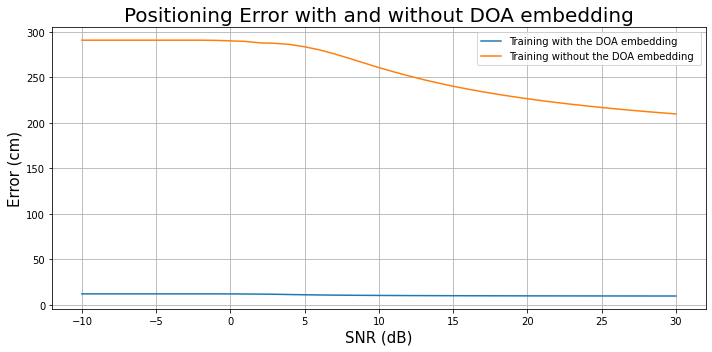

In [499]:
plt.figure(figsize=(10,5))
plt.plot(list(range(-10,31)),error_snr_withDOA, label='Training with the DOA embedding')
plt.plot(list(range(-10,31)),error_snr_withoutDOA,label='Training without the DOA embedding ')
# plt.plot(list(range(-10,31)),error_snr_allSNR,label='Training on the data of all SNR ')
plt.title(f'Positioning Error with and without DOA embedding (100epochs)',size=20)
plt.xlabel('SNR (dB)',size=15)
plt.ylabel('Error (cm)',size=15)
plt.grid()
plt.legend(title_fontsize=100)
plt.savefig(f'DOA Embedding.png')
plt.tight_layout()
plt.show()


In [ ]:
names = ['group_a', 'group_b', 'group_c']
values = [1, 10, 100]

plt.figure(figsize=(9, 3))

plt.bar(names, values)
plt.suptitle('Categorical Plotting')
plt.show()

#### Test Scenario 3: 
1. the test data is different from the training data. The test data is generated with three different SNR. 
2. For example, the batch_size is 20, one of the 20 data, only the first one is valid, the remaining ones will be 0, just to conform with the batch_size during the training.

`Result`: The result is 100% accurate if the same data is put into the model. 